#**Fake Job Offer Tweets Analysis and Summarization**

# Install Required Libraries

In [5]:
pip install tweepy pandas

In [63]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=dc7e7a8ca4074197a0cec9093ede76b8e695b28fbd2ba2278e8b6a485ab4978d
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


# Authenticate with the Twitter API

In [6]:
import tweepy

# Add your API credentials
api_key = "Oajz66mPkjDhNTxl1zYbt94kV"
api_secret = "yp0i9eFM5SVou3UozdMxet7bq2i7m7UlMfyFEoVTFvWbjdJkYK"
bearer_token = "AAAAAAAAAAAAAAAAAAAAABC5yQEAAAAA2ZsT1324h0y0YuG6W3%2FaXdVdwlk%3DiLcF1dFC47bI7ZoEFj0CjrmfNjAjJnmbm0iInrBxYwEwKfMgDQ"
access_token = "1412682180468240391-Sle9f567rWK8EYjPhgyALRrTUccwf1"
access_token_secret = "h6ZX4nea4fWZsOBK5ohtO0UQ4IjfKKUsWOm3or74sW6K1"

# Authenticate with the API
client = tweepy.Client(bearer_token=bearer_token,
                       consumer_key=api_key,
                       consumer_secret=api_secret,
                       access_token=access_token,
                       access_token_secret=access_token_secret)


In [7]:
import pandas as pd
import time

# Fetch Tweets Based on Query

In [8]:
# Query for tweets
query = '("fake job offer" OR "job scam") lang:en -is:retweet'

# Parameters
max_results = 100  # Max results per request
total_tweets = 100  # Total number of tweets to fetch
tweets = []  # List to store tweets
next_token = None

# Fetch tweets
while len(tweets) < total_tweets:
    response = client.search_recent_tweets(
        query=query,
        max_results=max_results,
        tweet_fields=["created_at", "text", "author_id", "lang"]
    )

    if response.data:
        tweets.extend(response.data)

    # Check if there's a next token for pagination
    if "next_token" in response.meta:
        next_token = response.meta["next_token"]
    else:
        break

# Process the tweets into a DataFrame
processed_tweets = [{
    "author_id": tweet.author_id,
    "created_at": tweet.created_at,
    "text": tweet.text
} for tweet in tweets]

df = pd.DataFrame(processed_tweets)

# Save to CSV
output_file = "fake_job_offer_tweets.csv"
df.to_csv(output_file, index=False)

print(f"Tweets saved to {output_file}")

Tweets saved to fake_job_offer_tweets.csv


# Clean and Preprocess Tweet Text

In [77]:
import re

# Load the dataset
df = pd.read_csv("fake_job_offer_tweets.csv")

# Clean the tweet text to remove URLs, mentions, hashtags, and special characters
def clean_text(text):
    # Remove URLs, mentions, hashtags, and special characters
    text = re.sub(r'http\S+|www\S+|@\S+|#\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

# Apply cleaning function to the 'text' column
df['cleaned_text'] = df['text'].apply(clean_text)

# Drop rows where 'cleaned_text' is missing (NaN)
df = df.dropna(subset=['cleaned_text'])

# Verify that missing values are dropped
print(f"Rows after dropping missing values: {df.shape[0]}")

# Drop duplicates based on the cleaned text
df = df.drop_duplicates(subset=["cleaned_text"], keep="first")


Rows after dropping missing values: 100


# Identify Tweets Mentioning Victims

In [78]:
victim_keywords = ["scammed", "fraud", "lost money", "victim", "scam", "job fraud", "job scam", "fake job offer"]

# Function to identify tweets mentioning a victim
def identify_victims(text):
    for keyword in victim_keywords:
        if keyword in text:
            return True
    return False

# Apply the function to identify victims
df['is_victim'] = df['cleaned_text'].apply(identify_victims)

# Filter out only the tweets where victims are mentioned
victims_df = df[df['is_victim'] == True]

# Word Cloud for Victim Tweets

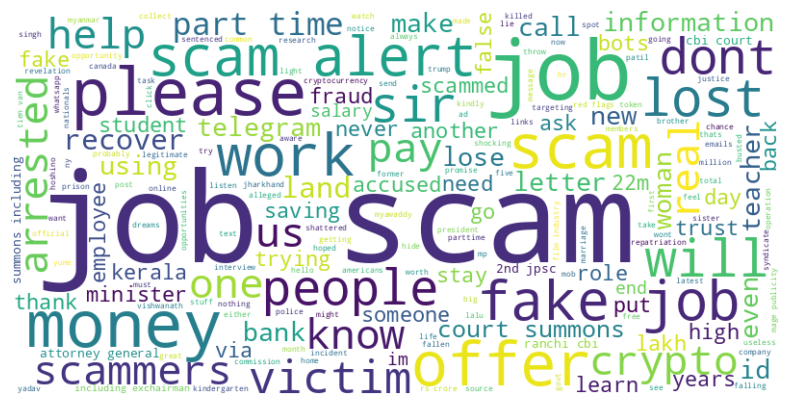

In [79]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all victim tweets into one large text
text = " ".join(victims_df['cleaned_text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [80]:
import pandas as pd
import spacy
from transformers import pipeline

In [81]:
# Load your CSV file
tweets_df = pd.read_csv('fake_job_offer_tweets.csv')

# Extract Key Sentences Using spaCy

In [82]:
nlp = spacy.load('en_core_web_sm')

def extract_key_sentence(tweet):
    doc = nlp(tweet)
    key_sentences = [sent.text for sent in doc.sents if any(ent.label_ == "PERSON" for ent in sent.ents)]
    return " ".join(key_sentences) if key_sentences else next(doc.sents).text

# Summarize Tweets Using BART Transformer

In [83]:
# Summarize Tweets
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

Device set to use cpu


In [87]:
# Function to summarize the tweet
def summarize_tweet(tweet):
    if not tweet or len(tweet.split()) < 5:  # Handle short or empty input
        return "Text too short for summarization"

    try:
        # Extract the tweet text to summarize
        input_length = len(tweet.split())

        # Set max_length to be no larger than input_length
        max_len = min(50, input_length)  # Set max_len to the smaller of 50 or input_length
        min_len = max(1, max_len // 2)   # Set min_len to at least half of max_len

        # Summarize the tweet
        summary = summarizer(
            tweet,
            max_length=max_len,
            min_length=min_len,
            do_sample=False
        )
        return summary[0]['summary_text']
    except Exception as e:
        logging.error(f"Error summarizing tweet: {e}")
        return "Error during summarization"

In [88]:
# Apply summarization in batches
batch_size = 50
summarized_batches = []

# Process tweets in batches
for i in range(0, len(victims_df), batch_size):
    batch = victims_df['cleaned_text'][i:i + batch_size]  # Use 'cleaned_text'

    # Apply summarization to each batch and handle errors
    summaries = batch.apply(lambda x: summarize_tweet(x) if pd.notnull(x) else "Summary not available")
    summarized_batches.extend(summaries)

# Verify lengths match before assigning summaries
if len(summarized_batches) == len(victims_df):
    # Assign summaries back to the original DataFrame
    df.loc[df['is_victim'] == True, 'summary'] = summarized_batches
else:
    raise ValueError("Mismatch between number of summaries and victim rows!")

# Optional: Filter again to get only victim-related rows
victims_df = df[df['is_victim'] == True]

In [89]:
# Save Results
victims_df.to_csv("summarized.csv", index=False)
print("Summarization completed and saved to summarized.csv")

Summarization completed and saved to summarized.csv


# Evaluate Summarization Using ROUGE

In [90]:
from rouge_score import rouge_scorer

# Example: Calculate ROUGE score
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = []

for generated, reference in zip(victims_df['summary'], victims_df['cleaned_text']):  # Replace with your ground truth
    score = scorer.score(reference, generated)
    scores.append(score)

# Average ROUGE scores
rouge_1_avg = sum([s['rouge1'].fmeasure for s in scores]) / len(scores)
rouge_2_avg = sum([s['rouge2'].fmeasure for s in scores]) / len(scores)
rouge_L_avg = sum([s['rougeL'].fmeasure for s in scores]) / len(scores)

print(f"ROUGE-1: {rouge_1_avg}, ROUGE-2: {rouge_2_avg}, ROUGE-L: {rouge_L_avg}")

ROUGE-1: 0.7806317621290944, ROUGE-2: 0.7441307905635112, ROUGE-L: 0.7490724606921748
